# Evaluation of B.1.1.7 likelihood fits

The B117 likelihood fit determins the development in the **fraction** of B.1.1.7 $f_B$ among the positive tests. However, the fit assumes that the samples for Whole Genome Sequencing (WGS) are drawn **randomly**, which may not be the case.

In order to evaluate this binned LLH fit numerically, a large number of samples based on the random assumption (and hence Poisson) are produced, and the LLH value in data is compared to the distribution of these LLH values.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scipy 
# from scipy.optimize import curve_fit, minimize
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True

***

# Fit of B.1.1.7 fraction:

## Read the data:

The data - which is based on single cases - is organised into a daily count of positives with and without B.1.1.7.

In [2]:
table = pd.read_excel('2021-02-09_WGS_Data.xlsx')
Nb117  = []
Ntotal = []
dates  = []

for date, data in table.groupby('date_sampling'): 
    Nb117.append( len(data['clade'][data['clade'] == '20I/501Y.V1']) ) # determine number segmented to clade given day
    Ntotal.append( len(data['clade']) )                                # determine number segmented totally
    dates.append(date)                                                 # Store dates, sorted by group

# Set number of days to include in the fit (i.e. days back in time):
Ndays = 60
Ndays = 35

# Set the average time between generation (in days):
tG = 4.7

# Get numpy arrays of the counts and the fraction of B.1.1.7:
Nb117, Ntotal = np.array(Nb117), np.array(Ntotal)
frac = Nb117/Ntotal

for i in range(len(frac)-Ndays,len(frac)) :
    print(f"  Days back in time: {len(frac)-i:2d}     date: {dates[i]}   N(B117) = {Nb117[i]:3.0f}  Ntotal = {Ntotal[i]:4.0f}   frac = {frac[i]:5.3f}")

  Days back in time: 35     date: 2020-12-31 00:00:00   N(B117) =  17  Ntotal =  488   frac = 0.035
  Days back in time: 34     date: 2021-01-01 00:00:00   N(B117) =  13  Ntotal =  804   frac = 0.016
  Days back in time: 33     date: 2021-01-02 00:00:00   N(B117) =  20  Ntotal = 1262   frac = 0.016
  Days back in time: 32     date: 2021-01-03 00:00:00   N(B117) =  12  Ntotal =  791   frac = 0.015
  Days back in time: 31     date: 2021-01-04 00:00:00   N(B117) =  17  Ntotal =  936   frac = 0.018
  Days back in time: 30     date: 2021-01-05 00:00:00   N(B117) =  35  Ntotal = 1051   frac = 0.033
  Days back in time: 29     date: 2021-01-06 00:00:00   N(B117) =  12  Ntotal =  447   frac = 0.027
  Days back in time: 28     date: 2021-01-07 00:00:00   N(B117) =   7  Ntotal =  352   frac = 0.020
  Days back in time: 27     date: 2021-01-08 00:00:00   N(B117) =  21  Ntotal =  778   frac = 0.027
  Days back in time: 26     date: 2021-01-09 00:00:00   N(B117) =  17  Ntotal =  671   frac = 0.025


## Define fitting function and model:

In [3]:
# Fitting function:
def func_logistic(t, frac_t0, tau) :
    return frac_t0*np.exp(t/tau) / ((1-frac_t0) + frac_t0*np.exp(t/tau))

# Binned likelihood fit model:
def model_bllh(x, N_obs, frac_t0, tau):
    N_exp = func_logistic(x, frac_t0, tau) * Ntotal[-Ndays:]
    return -2*sum( stats.poisson.logpmf( N_obs, N_exp ) )

In [4]:
# Fit the fraction:
minuit_obj = Minuit(lambda frac_t0, tau: model_bllh(np.arange(-len(frac[-Ndays:]), 0), Nb117[-Ndays:], frac_t0, tau), 
                    frac_t0=0.26, tau=12.0, error_frac_t0 = 0.05, error_tau=1.0, errordef=0.5)
minuit_obj.errordef = 0.5
minuit_obj.migrad()   
if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
    print("  WARNING: The Likelihood fit DID NOT converge!!!")

# Record the fit results and print them:
frac_t0_fit, dfrac_t0_fit = minuit_obj.params[0].value, minuit_obj.params[0].error
tau_fit, dtau_fit         = minuit_obj.params[1].value, minuit_obj.params[1].error
factor_B117 = np.e**(tG/tau_fit)
efactor_B117 = np.e**(tG/tau_fit) * (tG/tau_fit**2) * dtau_fit
print(f"   Frac_t0: {frac_t0_fit:5.3f} +- {dfrac_t0_fit:5.3f}   Tau: {tau_fit:5.1f} +- {dtau_fit:3.1f}    factor_B117 = {factor_B117:4.2f} +- {efactor_B117:4.2f}") 
print(f"   Minuit LLH value: {minuit_obj.fval:5.2f}")

   Frac_t0: 0.261 +- 0.008   Tau:  11.8 +- 0.3    factor_B117 = 1.49 +- 0.02
   Minuit LLH value: 235.60


## Plot the fit result and extrapolate into future:

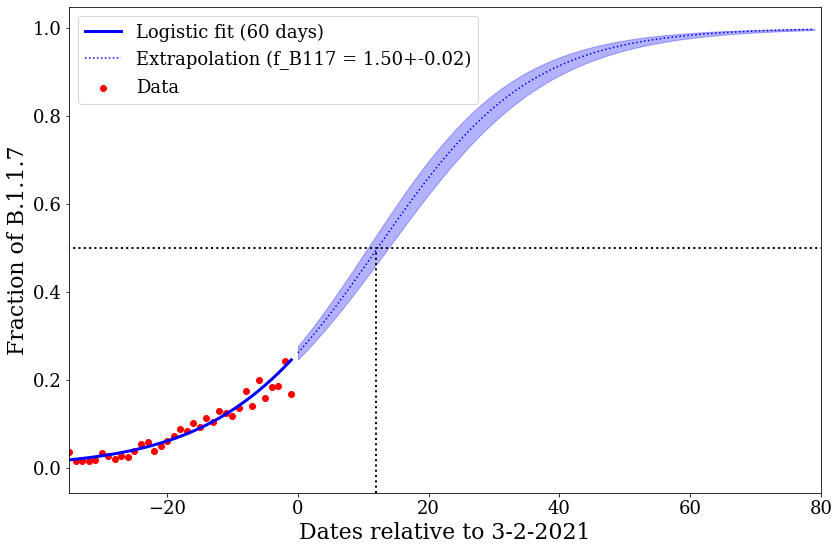

In [5]:
Nsig = 2.0      # Number of sigmas to change parameters for error band!
Nfuture = 80

plt.figure(figsize=(12,8))
plt.scatter(np.arange(-len(frac),0), frac, color='r', label='Data')

plt.plot(np.arange(-Ndays,0),  func_logistic(np.arange(-Ndays,0),  *[frac_t0_fit, tau_fit]), label='Logistic fit (60 days)', color="blue", linewidth=3)
plt.plot(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit, tau_fit]), label='Extrapolation (f_B117 = 1.50+-0.02)', color="blue", linestyle=":")
plt.legend()

# Plot an "envelope" of possible predictions:
plt.fill_between(np.arange(0,Nfuture), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit+Nsig*dfrac_t0_fit, tau_fit-Nsig*dtau_fit]), func_logistic(np.arange(0,Nfuture), *[frac_t0_fit-Nsig*dfrac_t0_fit, tau_fit+Nsig*dtau_fit]), color='blue', alpha=0.3)

# Show estimate of "British take-over":
plt.axhline(y=0.5,  xmin=-Ndays, xmax=Nfuture, color='black', linewidth=2.0, linestyle="dotted")
plt.axvline(x=12.0, ymin=0.0,    ymax=0.5,     color='black', linewidth=2.0, linestyle="dotted")

plt.xlim(-Ndays,Nfuture)
plt.ylabel('Fraction of B.1.1.7', fontsize=22)
plt.xlabel('Dates relative to '+str(dates[-1].day)+'-'+str(dates[-1].month)+'-'+str(dates[-1].year), fontsize=22 )

plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_FitOfB117fraction_SingleFit.pdf")

## Discussion of "lifetime":

The "lifetime" $\tau = 12.7 \pm 0.7$ days from the fit suggests, that it takes about 12.7 days for B.1.1.7 to grow by a factor $e = 2.72$, and thus given a generation time of $t_G = 4.7~\mbox{days}$, that the infection rate from B.1.1.7 is the following factor greater than the current dominant variant in Denmark:

$$\tau = 12.7~\mbox{days} \longrightarrow \beta_{B117} = \beta \times e^{4.7/12.7} = \beta \times 1.45$$

In [6]:
factor_B117 = np.e**(tG/tau_fit)
efactor_B117 = np.e**(tG/tau_fit) * (tG/tau_fit**2) * dtau_fit
print(f"  factor_B117 = {factor_B117:4.2f} +- {efactor_B117:4.2f}")

  factor_B117 = 1.49 +- 0.02


***

# Evaluation of LLH fit:

In the following, data is simulated based on the above fit parameters, and these are then refitted to get the LLH-value. From the distribution of LLH-values, the original fit can be evaluated.

In [7]:
Ntest = 1000
LLHvalues = np.array([])

r = np.random
r.seed(42)  
Nt = len(Ntotal)

for itest in range(Ntest) :

    # Generate the data:
    Nexp = func_logistic(np.arange(-Ndays,0), *[frac_t0_fit, tau_fit]) * Ntotal[Nt-Ndays:Nt]
    Nobs = r.poisson(Nexp)
    frac_test = Nobs/Ntotal[Nt-Ndays:Nt]
    # print(Ntotal[Nt-Ndays:Nt], exp, obs, frac_test)
    
    # Fit this data:
    minuit_obj = Minuit(lambda frac_t0, tau: model_bllh(np.arange(-len(frac_test[-Ndays:]), 0), Nobs[-Ndays:], frac_t0, tau), 
                    frac_t0=0.26, tau=12.0, error_frac_t0 = 0.05, error_tau=1.0, errordef=0.5)
    minuit_obj.errordef = 0.5
    minuit_obj.migrad()   

    # Check if fit converged:
    if (not minuit_obj.fmin.is_valid) :                                   # Check if the fit converged
        print("  WARNING: The Likelihood fit DID NOT converge!!!")
        # plt.scatter(np.arange(-len(frac),0), frac_test, color='b', label='Sim. Data')
    else :  
        # If so, record the fit results and print the first ones:
        LLHvalues = np.append(LLHvalues, minuit_obj.fval)
        if (itest < 20) :
            print(LLHvalues[-1])
    

223.76089894677514
234.97709737793974
218.18441112354108
219.4205936994207
241.41066384523742
217.09659290207878
223.50964924112978
220.15100814508907
222.46926727289758
217.25134545668504
212.123286108117
225.3482088000899
232.1513609221132
230.09071259459506
224.917082595736
219.8948390108464
226.90617542114913
224.59972285960544
227.88489974615638
225.97655789520792


## Plot likelihood values and check fit quality:

Number of LLH values: 1000 / 1000


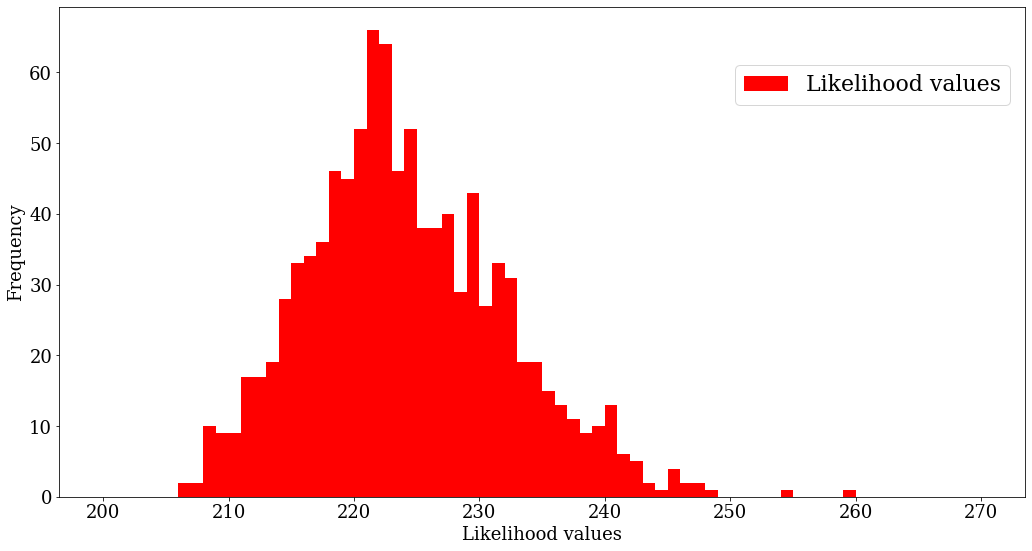

In [11]:
print(f"Number of LLH values: {len(LLHvalues):4d} / {Ntest:4d}")

fig2, ax2 = plt.subplots(figsize=(15, 8))
ax2.set(xlabel="Likelihood values", ylabel="Frequency", title="")
#ax2.hist(LLHvalues, bins=70, range=(290.0,360.0), linewidth=2, label='Likelihood values', color='red')    # 60 days
ax2.hist(LLHvalues, bins=70, range=(200.0,270.0), linewidth=2, label='Likelihood values', color='red')     # 35 days

ax2.legend(loc=(0.70, 0.80), fontsize=22)
plt.tight_layout()
if (save_plots) :
    plt.savefig("fig_LLHvaluesDistribution.pdf")
